# PyTorch🔥Simple Neural Network for IRIS Classification

Subject: Simple, linear neural network with Torch for IRIS classification.

Data: Canonical Iris dataset (via sklearn.datasets.load_iris())

Procedure:
- visualize data distribution
- split into train/test with torch.utils.data.random_split
- tensorize and create from torch.utils.data.DataLoader
- scale with sklearn.preprocessing.StandardScaler
- neural network with torch.nn.Module, consisting of input and two hidden torch.nn.Linear layers, with torch.nn.functional.relu inbetween and torch.nn.functional.softmax at the end
- visualize model with torchviz' make_dot()
- training with torch.nn.CrossEntropyLoss and torch.optim.Adam
- visualize loss and accuracy
- display a ROC curve
- (expected) good results

Others:
- CUDA support

Sources used:
- https://janakiev.com/blog/pytorch-iris/

## Bootstrap and Imports

In [9]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on {DEVICE}')

if IN_COLAB := 'google.colab' in str(get_ipython()):
  NUM_EPOCHS = 500
  !pip install torchviz

else:
  NUM_EPOCHS = 30

Running on cuda


In [10]:
from __future__ import print_function
import random
import time
from collections.abc import Callable

import numpy as np
from tqdm.auto import tqdm
#import tqdm

from IPython.display import HTML, Image

import matplotlib.animation as animation
import matplotlib.pyplot as plt
#%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn.functional as F  # todo remove
from torch import nn
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import make_grid
from torchvision import utils
from torch.utils.data import DataLoader, random_split
from torch.nn.modules.loss import _Loss
from torchviz import make_dot

my_seed = 123
random.seed(my_seed)
torch.manual_seed(my_seed)
np.random.seed(my_seed)

In [11]:
def get_describe_only_once() -> Callable:
    already_described = set()

    def _describe_only_once(tensor: torch.Tensor, name: str):
        if name in already_described:
            return
        already_described.add(name)
        if hasattr(tensor, 'shape'):
            print(f"{name} is a {type(tensor)} of size {tensor.shape} with dtype {tensor.dtype}.")
        else:
            print(f"{name} is a {type(tensor)} with content {tensor}.")
    return _describe_only_once

describe_only_once = get_describe_only_once()

## Download and Visualize Data

In [12]:
BATCH_SIZE = 2

In [13]:
# download and save iris data
iris = load_iris()
x_ = iris['data']  # numpy.ndarray (150, 4) of dtype float64, i.e. double
x = x_.astype('float32')  # dtype float32 (default for torch models)
y = iris['target']  # numpy.ndarray (150,)
names = iris['target_names']  # numpy.ndarray (3,)
feature_names = iris['feature_names']  # list[str]

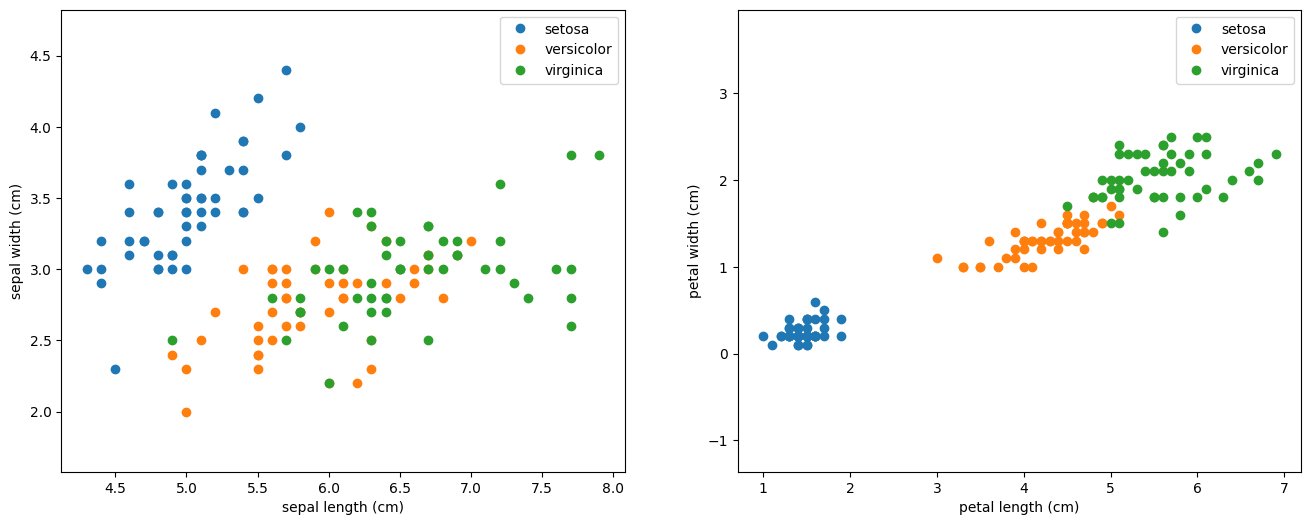

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for target, target_name in enumerate(names):
    X_plot = x[y == target]
    ax1.plot(X_plot[:, 0], X_plot[:, 1],
             linestyle='none',
             marker='o',
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();

for target, target_name in enumerate(names):
    X_plot = x[y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3],
             linestyle='none',
             marker='o',
             label=target_name)
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend();

## Dataset & DataLoader

In [15]:
# Scale data to have mean 0 and variance 1
# which is importance for convergence of the neural network
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)  # numpy.ndarray (150, 4) of dtype float32

iris_data = torch.from_numpy(x_scaled)  # [150, 4] of dtype torch.float32, i.e. default for torch models
# iris_data = iris_data.float()  # [150, 4], i.e. float
iris_labels = torch.from_numpy(y)  # [150] of dtype torch.int32

iris_dataset = torch.utils.data.TensorDataset(iris_data, iris_labels)

# split into train and test datasets
len_train = round(iris_data.shape[0] * .75)  # 112
len_test = iris_data.shape[0] - len_train  # 38
train_dataset, test_dataset = random_split(iris_dataset, (len_train, len_test))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [20]:
# print some example rows
dataiter = iter(train_loader)
train_batch, labels_batch = next(dataiter)  # train_batch: [2, 4], labels_batch: [2]
train_batch = train_batch.to(DEVICE)
labels_batch = labels_batch.to(DEVICE)
for i in range(BATCH_SIZE):
    print(f'X = {train_batch[i]} -> {labels_batch[i]}')

X = tensor([ 1.0380, -1.2830,  1.1606,  0.7907], device='cuda:0') -> 2
X = tensor([-0.6583,  1.4794, -1.2834, -1.3154], device='cuda:0') -> 0


## Classifier

In [21]:
class Classifier(nn.Module):
    def __init__(self, input_dim: int):  # todo sequential
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, 3)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

tensor([-0.6583,  1.4794, -1.2834, -1.3154], device='cuda:0')
Classifier(
  (layer1): Linear(in_features=4, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
)


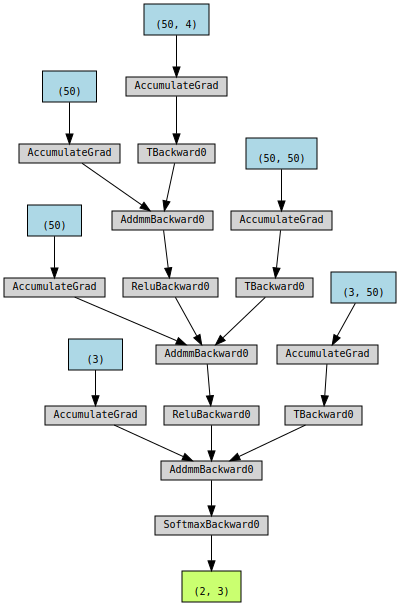

In [22]:
# visualize the classifier
c_temp = Classifier(input_dim=4).to(DEVICE)  # train data size
# to visualize with torchviz, we need some input that can pass through the model's forward() method.
print(train_batch[i])
classifier_predictions = c_temp(train_batch)  # [2, 3]
print(c_temp)
make_dot(classifier_predictions)

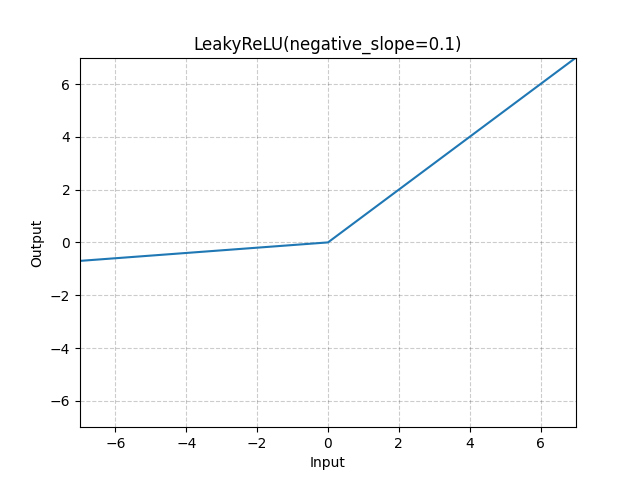

In [23]:
Image("https://pytorch.org/docs/stable/_images/LeakyReLU.png")

## Training

In [24]:
LEARNING_RATE = 0.001

classifier = Classifier(input_dim = 4)
optimizer = torch.optim.Adam(classifier.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

In [25]:
def get_test_accuracy(classifier: Classifier, dataset: DataLoader):

    y_pred_test = classifier(X_test)
    correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
    accuracy_list[epoch] = correct.mean()

In [26]:
from torch.autograd import Variable

# x_test: [38, 4] of dtype torch.float32, y_test: [38] of dtype torch.int32
x_test, y_test = iris_dataset[test_dataset.indices]

loss_list = np.zeros((NUM_EPOCHS,))
accuracy_list = np.zeros((NUM_EPOCHS,))

for epoch in tqdm(range(NUM_EPOCHS)):

    for x_train_batch, y_train_batch_ in train_loader:  # x_train_batch: [2, 4], y_train_batch: [2]

        # torch expects a LongTensor as target
        y_train_batch = y_train_batch_.long()

        #describe_only_once(y_train, "y_train")

        y_pred_batch = classifier(x_train_batch)  # [2, 3] of dtype torch.float32
        # print(y_pred_batch)
        # describe_only_once(y_pred_batch, "y_pred_batch")

        loss = loss_fn(y_pred_batch, y_train_batch)
        loss_list[epoch] = loss.item()

        # Zero gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_pred_test = classifier(x_test)  # [38, 3] of dtype torch.float32
            correct = (torch.argmax(y_pred_test, dim=1) == y_test).type(torch.FloatTensor)  # [38] of dtype torch.float32
            accuracy_list[epoch] = correct.mean()

  0%|          | 0/500 [00:00<?, ?it/s]

## Visualization

Text(0.5, 0, 'epochs')

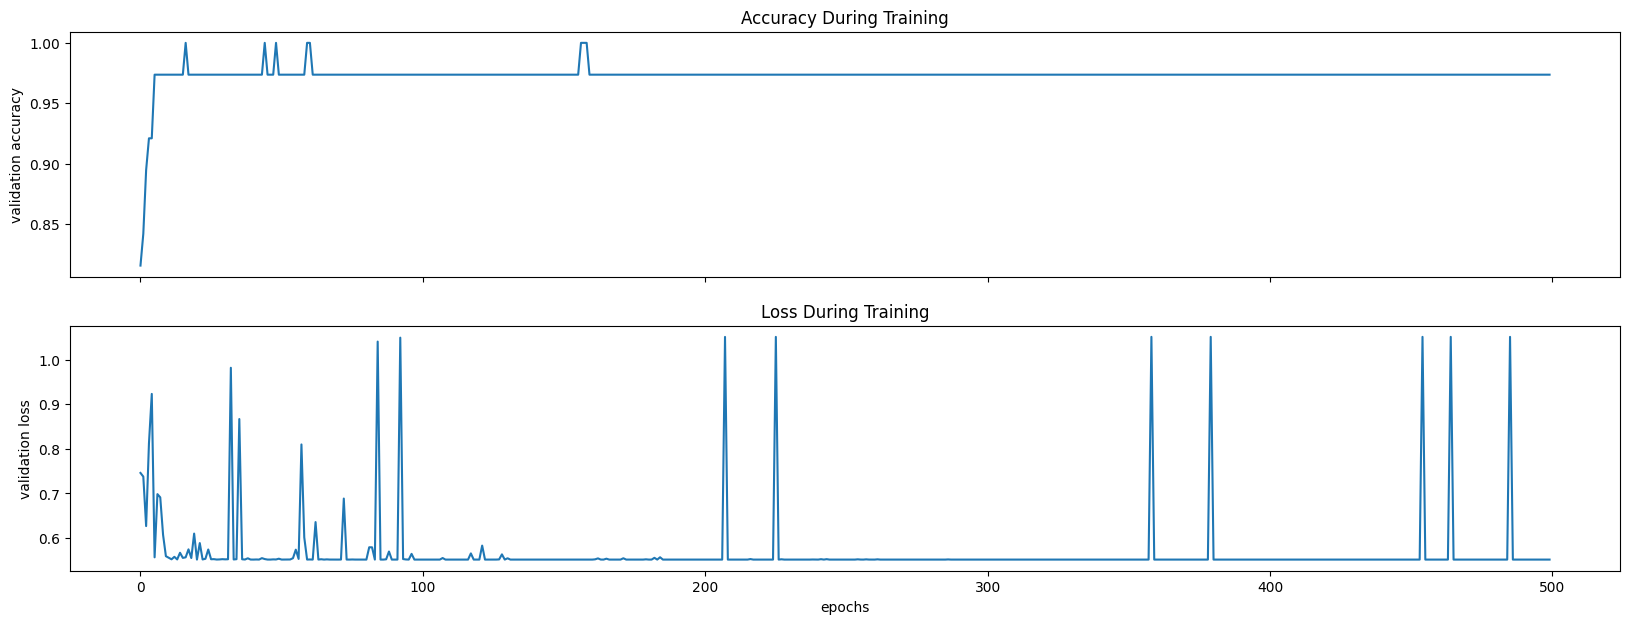

In [27]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(20, 7), sharex=True)

ax1.set_title("Accuracy During Training")
ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")

ax2.set_title("Loss During Training")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs")

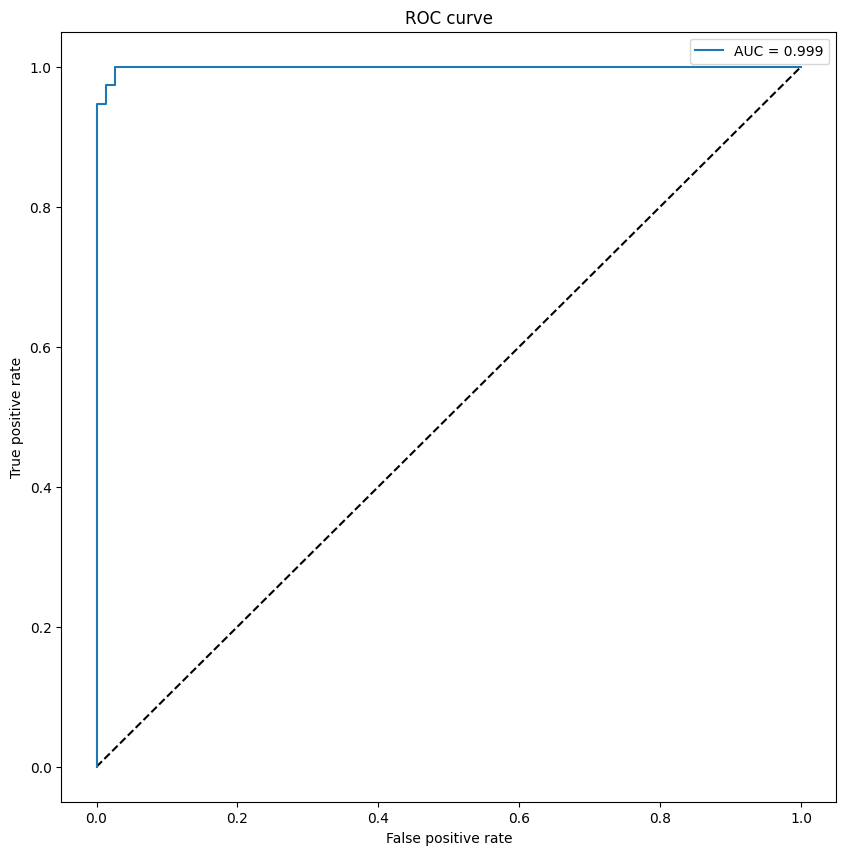

In [28]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = classifier(x_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())

plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();